## **TRANSFER LEARNING (VGG16)**


In [1]:
# SOLO PARA USO EN GOOGLE COLABORATORY
# Para conectar el notebook con la cuenta de gdrive
from google.colab import drive
drive.mount('/content/drive/')

BASE_FOLDER = '/content/drive/My Drive/Nuclio/DL/Clases/' # Ajustar el directorio raíz de Google Drive

Mounted at /content/drive/


#### **- Cargando el conjunto de datos**

In [2]:
from tensorflow.keras.datasets import cifar10
from sklearn.preprocessing import LabelBinarizer

# Importando y normalizando el set de datos CIFAR10
((trainX, trainY), (testX, testY)) = cifar10.load_data()
labelNames = ["Avión", "Automóvil", "Pájaro", "Gato", "Ciervo", "Perro", "Rana", "Caballo", "Barco", "Camión"]

170498071/170498071 [==============================] - 11s 0us/step


#### **- Acondicionando el conjunto de datos como en la VGG16**

In [3]:
''' PREPROCESAMOS NUESTRAS IMAGENES DE LA MISMA FORMA QUE SE HIZO EN EL MODELO
QUE HEMOS ELEGIDO
SE VE EN LA DOCUMENTACIÓN POR CADA MODELO
'''

# PREPROCESADO DE DATOS
print(trainX.max())
print(trainX.min())

# Pasamos las etiquetas a One-hot encoding
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# IMPORTANTE: Se normalizan los datos como se normalizaron en el entrenamiento con ImageNet!!
from tensorflow.keras.applications import vgg16 # importar la que corresponda con la red que queremos usar
trainX = vgg16.preprocess_input(trainX)
testX = vgg16.preprocess_input(testX)

print(trainX.max())
print(trainX.min())

255
0
151.061
-123.68


#### **- Cargando la topología de CNN (base model)**

In [4]:
# Keras incluye varias arquitecturas
# VGG16, VGG19, ResNet50, Xception, InceptionV3, InceptionResNetV2, MobileNetV2, DenseNet, RasNet
# documentacion https://keras.io/applications/

from tensorflow.keras.applications import VGG16

#PARTE CONVOLUCIONAL
base_model = VGG16(weights='imagenet', #cogemos pesos del dataset de imagenet
                 include_top=False, # No incluir el Top Model (parte destinada a la clasificación)
                 input_shape=(32,32,3)) #dimension de NUESTROS datos de entrada
base_model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

#### **- TRANSFER LEARNING: Creando top model y congelando base model**

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

base_model.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING

pre_trained_model = Sequential()

# Conectar el base model preentrenado a nuestro top model
pre_trained_model.add(base_model)

# Crear top model
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(layers.Dense(256, activation='relu'))
pre_trained_model.add(layers.Dense(10, activation='softmax'))

pre_trained_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14848586 (56.64 MB)
Trainable params: 133898 (523.04 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


#### **- TRANSFER LEARNING: Entrenando modelo**

[INFO]: Compilando el modelo...
[INFO]: Entrenando la red...
Epoch 1/20
313/313 [==============================] - 10s 27ms/step - loss: 3.4653 - accuracy: 0.5096 - val_loss: 2.0689 - val_accuracy: 0.5558
Epoch 2/20
313/313 [==============================] - 6s 19ms/step - loss: 1.5138 - accuracy: 0.6147 - val_loss: 1.5959 - val_accuracy: 0.5886
Epoch 3/20
313/313 [==============================] - 6s 20ms/step - loss: 1.0698 - accuracy: 0.6750 - val_loss: 1.4284 - val_accuracy: 0.6060
Epoch 4/20
313/313 [==============================] - 7s 21ms/step - loss: 0.8526 - accuracy: 0.7222 - val_loss: 1.3552 - val_accuracy: 0.6163
Epoch 5/20
313/313 [==============================] - 7s 21ms/step - loss: 0.7130 - accuracy: 0.7605 - val_loss: 1.3188 - val_accuracy: 0.6244
Epoch 6/20
313/313 [==============================] - 6s 21ms/step - loss: 0.6142 - accuracy: 0.7909 - val_loss: 1.3253 - val_accuracy: 0.6248
Epoch 7/20
313/313 [==============================] - 6s 20ms/step - loss: 0.535

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[INFO]: Evaluando el modelo...
79/79 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

       Avión       0.72      0.66      0.69      1000
   Automóvil       0.71      0.73      0.72      1000
      Pájaro       0.51      0.58      0.54      1000
        Gato       0.50      0.43      0.47      1000
      Ciervo       0.55      0.59      0.57      1000
       Perro       0.55      0.57      0.56      1000
        Rana       0.65      0.64      0.64      1000
     Caballo       0.69      0.65      0.66      1000
       Barco       0.75      0.74      0.75      1000
      Camión       0.66      0.70      0.68      1000

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.63      0.63      0.63     10000



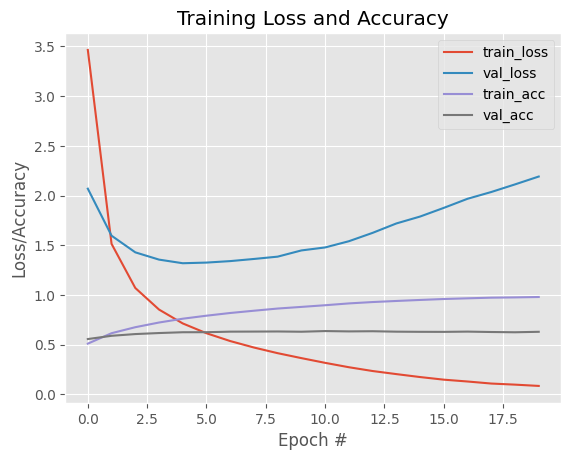

In [ ]:
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from google.colab import drive

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
pre_trained_model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0005), metrics=["accuracy"])

# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_pre = pre_trained_model.fit(trainX, trainY, batch_size=128, epochs=20, validation_split=0.2)

# Montamos la unidad de Drive
drive.mount('/content/drive')
# Almacenamos el modelo empleando la función mdoel.save de Keras
pre_trained_model.save(BASE_FOLDER+"deepCNN_CIFAR10_pretrained.h5")

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")

# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = pre_trained_model.predict(testX, batch_size=128)

# Sacamos el report para test
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H_pre.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H_pre.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H_pre.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H_pre.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

## **TRANSFER LEARNING + FINE TUNING (ResNet50)**

#### **- Cargando el conjunto de datos**

In [6]:
from tensorflow.keras.datasets import cifar10

# Importando y normalizando el set de datos CIFAR10
((trainX, trainY), (testX, testY)) = cifar10.load_data()
labelNames = ["Avión", "Automóvil", "Pájaro", "Gato", "Ciervo", "Perro", "Rana", "Caballo", "Barco", "Camión"]

#### **- Acondicionando el conjunto de datos como en la ResNet50**

In [7]:
from tensorflow.keras.utils import to_categorical

# PREPROCESADO DE DATOS
print(trainX.max())
print(trainX.min())

# Pasamos las etiquetas a One-hot encoding
trainY = to_categorical(trainY)
testY = to_categorical(testY)

# IMPORTANTE: Se normalizan los datos como se normalizaron en el entrenamiento con ImageNet!!
from tensorflow.keras.applications import resnet # importar la que corresponda con la red que queremos usar
trainX = resnet.preprocess_input(trainX)
testX = resnet.preprocess_input(testX)

print(trainX.max())
print(trainX.min())

255
0
151.061
-123.68


#### **- Cargando la topología de CNN (base model)**

In [8]:
from tensorflow.keras.applications import ResNet50

# Importamos ResNet50 con pesos de imagenet y sin Top Model especificando tamaño de entrada de datos
base_model = ResNet50(weights='imagenet', #Los pesos del data set imagenet
                 include_top=False, # No incluir el Top Model ( lo haremos ad-hoc - parte destinada a la clasificación)
                 input_shape=(32,32,3)) #Como vienen nuestros datos de entrada

base_model.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                      

#### **- FINE TUNING: Creando top model y descongelando partes del base model**

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model

# Por defecto todas las capas estás a layer.trainable = True (entrenables)
# En base_model.layers.name tenemos la información del nombre de la capa
# Vamos congelando capas
# Reentrenamos a partir de la capa conv4_block6_1_conv
for layer in base_model.layers:
  if layer.name == 'conv4_block6_1_conv':
    break
  layer.trainable = False
  print('Capa ' + layer.name + ' congelada...')

# Añadimos nuestro clasificador (Top Model)
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(1024, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)
model = Model(base_model.input, x)


Capa input_2 congelada...
Capa conv1_pad congelada...
Capa conv1_conv congelada...
Capa conv1_bn congelada...
Capa conv1_relu congelada...
Capa pool1_pad congelada...
Capa pool1_pool congelada...
Capa conv2_block1_1_conv congelada...
Capa conv2_block1_1_bn congelada...
Capa conv2_block1_1_relu congelada...
Capa conv2_block1_2_conv congelada...
Capa conv2_block1_2_bn congelada...
Capa conv2_block1_2_relu congelada...
Capa conv2_block1_0_conv congelada...
Capa conv2_block1_3_conv congelada...
Capa conv2_block1_0_bn congelada...
Capa conv2_block1_3_bn congelada...
Capa conv2_block1_add congelada...
Capa conv2_block1_out congelada...
Capa conv2_block2_1_conv congelada...
Capa conv2_block2_1_bn congelada...
Capa conv2_block2_1_relu congelada...
Capa conv2_block2_2_conv congelada...
Capa conv2_block2_2_bn congelada...
Capa conv2_block2_2_relu congelada...
Capa conv2_block2_3_conv congelada...
Capa conv2_block2_3_bn congelada...
Capa conv2_block2_add congelada...
Capa conv2_block2_out congela

#### **- FINE TUNING: Entrenando modelo**

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

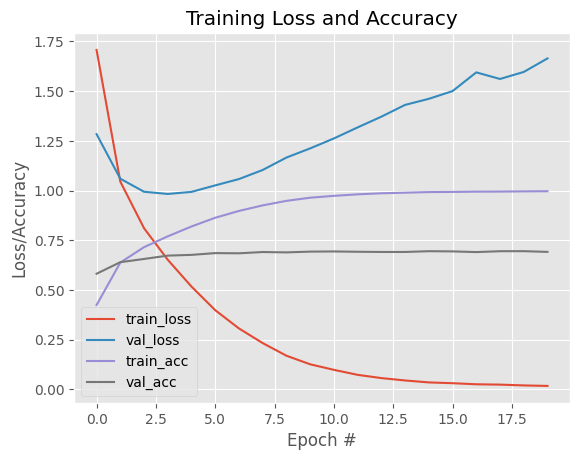

In [ ]:
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Compilamos el modelo
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Vamos a visualizar el modelo prestando especial atención en el número de pesos total y el número de pesos entrenables.
model.summary()

# Entrenamos el modelo
H = model.fit(trainX, trainY, validation_split=0.2, batch_size=256, epochs=20, verbose=1)

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")
predictions = model.predict(testX, batch_size=64)

# Obtener el report de clasificación
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()